In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
from scipy.signal import find_peaks
import seaborn as sns
sns.set_theme()

In [37]:
def time_series_load_csv(filename:str, frequency:str, column_date:int=1, index_column:int=0, use_time:bool=True) -> pd.DataFrame:
    time_series_df = pd.read_csv(filename, parse_dates=[column_date], index_col=index_column)
    
    date_format = '%Y-%m-%d %H:%M:%S' if use_time else '%Y-%m-%d'
    time_series_df['Date'] = pd.to_datetime(time_series_df['Date'], format=date_format)
    time_series_df.set_index('Date', inplace=True)
    
    time_series_df = time_series_df.asfreq(frequency)
    time_series_df.interpolate(method='linear', limit_direction='both', inplace=True)
    return time_series_df.squeeze()

In [38]:
df = time_series_load_csv(filename='freezerdata_clean 15-03 tm 19-03.csv', use_time=True, frequency='min')

In [39]:
df

,Door,EnergyKWh,Environment,HotGasPipe,LiquidPipe,Refrigerated,SuctionPipe,Time
Date,,,,,,,,
2023-03-14 23:00:00,0.0,100.0,19.90,18.9,18.3,19.2,19.00,0
2023-03-14 23:01:00,0.0,100.0,19.90,18.9,18.3,19.2,19.00,1
2023-03-14 23:02:00,0.0,100.0,19.90,18.9,18.5,19.4,19.10,2
2023-03-14 23:03:00,0.0,100.0,19.90,18.9,18.4,19.2,18.90,3
2023-03-14 23:04:00,0.0,100.0,19.90,18.9,18.4,19.3,19.00,4
...,...,...,...,...,...,...,...,...
2023-03-19 18:56:00,0.0,700.0,21.35,30.1,27.1,-3.5,10.05,6956
2023-03-19 18:57:00,0.0,700.0,21.40,39.7,29.2,-2.2,7.00,6957
2023-03-19 18:58:00,0.0,700.0,21.50,40.9,28.7,-2.0,6.40,6958


In [40]:
def variable_plot(dataframe: pd.DataFrame, column:list, titles:list) -> None:
    fig, axes = plt.subplots(len(columns), 1, figsize=(10, 5 * len(columns)))

    if len(column) == 1:
        axes = [axes]
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(column)))
    
    for i, (col, ax, color) in enumerate(zip(column, axes, colors)):
        ax.plot(dataframe['Time'], dataframe[col], color=color) 
        
        if i < 2:
            ax.set_ylabel(titles[i])
        else:
            ax.set_ylabel('Temperature (°C)')
        
        ax.set_title(titles[i])
        ax.set_xlabel('Time [min]')
        
    plt.tight_layout()
    plt.show()

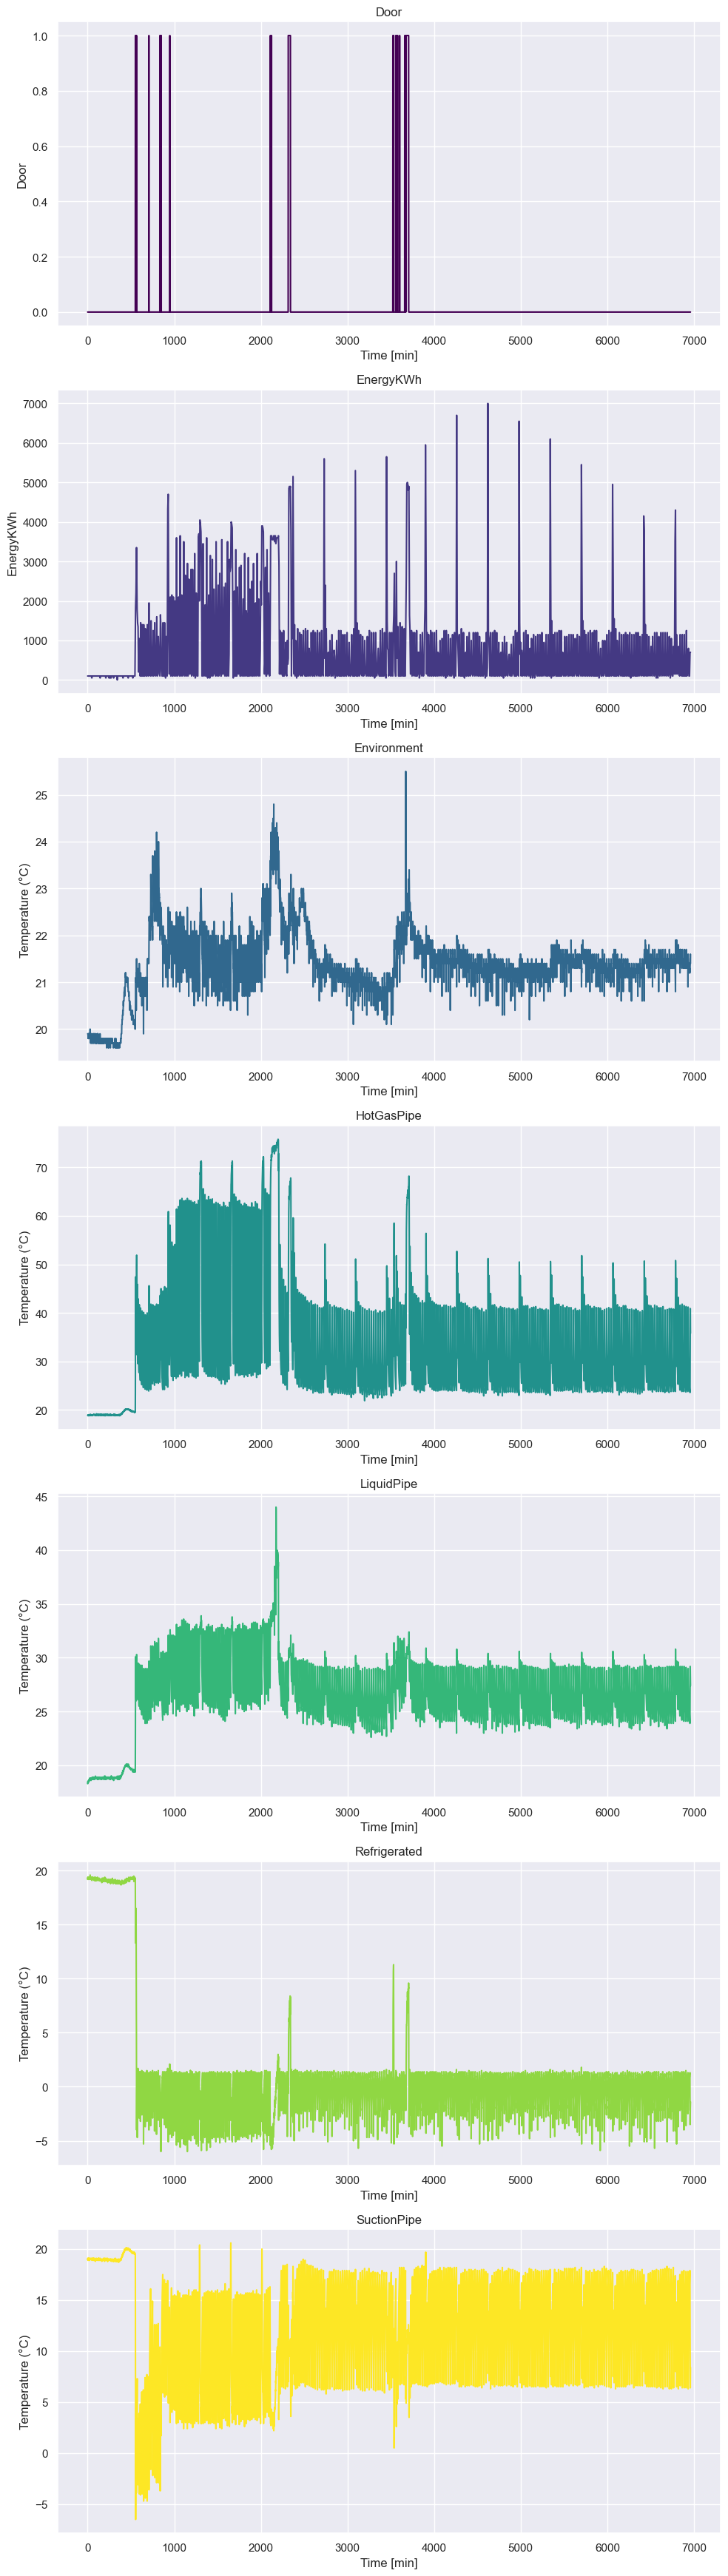

In [42]:
columns = ['Door', 'EnergyKWh', 'Environment', 'HotGasPipe', 'LiquidPipe', 'Refrigerated', 'SuctionPipe']
variable_plot(df, columns, titles=columns)

In [8]:
df2 = df.reset_index()
df2['Date'] = pd.to_datetime(df2['Date'])
df2

,Date,Door,EnergyKWh,Environment,HotGasPipe,LiquidPipe,Refrigerated,SuctionPipe,Time
0,2023-03-14 23:00:00,0.0,100.0,19.90,18.9,18.3,19.2,19.00,0
1,2023-03-14 23:01:00,0.0,100.0,19.90,18.9,18.3,19.2,19.00,1
2,2023-03-14 23:02:00,0.0,100.0,19.90,18.9,18.5,19.4,19.10,2
3,2023-03-14 23:03:00,0.0,100.0,19.90,18.9,18.4,19.2,18.90,3
4,2023-03-14 23:04:00,0.0,100.0,19.90,18.9,18.4,19.3,19.00,4
...,...,...,...,...,...,...,...,...,...
6956,2023-03-19 18:56:00,0.0,700.0,21.35,30.1,27.1,-3.5,10.05,6956
6957,2023-03-19 18:57:00,0.0,700.0,21.40,39.7,29.2,-2.2,7.00,6957
6958,2023-03-19 18:58:00,0.0,700.0,21.50,40.9,28.7,-2.0,6.40,6958
6959,2023-03-19 18:59:00,0.0,700.0,21.60,38.6,27.8,-1.6,7.20,6959


In [9]:
df2 = df2[df2['Date'].dt.day == 15]
df2.set_index('Date', inplace=True)

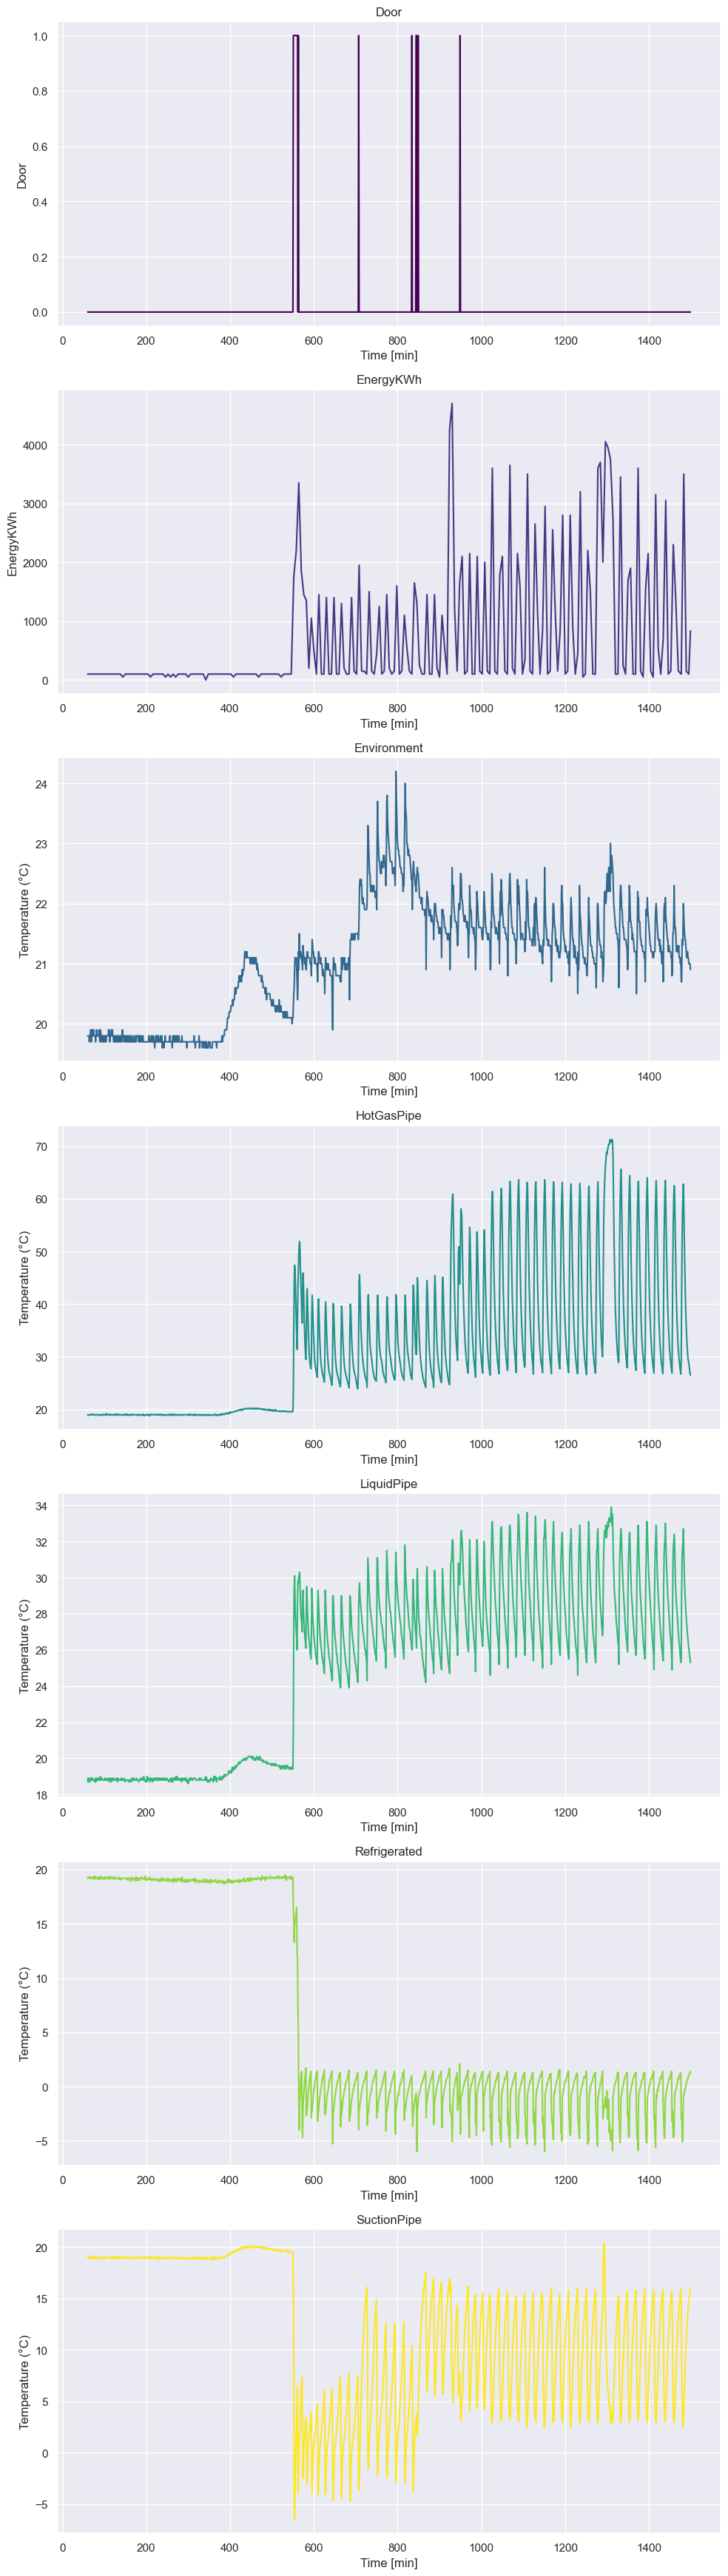

In [10]:
columns = ['Door', 'EnergyKWh', 'Environment', 'HotGasPipe', 'LiquidPipe', 'Refrigerated', 'SuctionPipe']
variable_plot(df2, column=columns, titles=columns)

In [11]:
df3 = df2[(df2['Time'] > 600) & (df2['Time'] < 901)]
df3

,Door,EnergyKWh,Environment,HotGasPipe,LiquidPipe,Refrigerated,SuctionPipe,Time
Date,,,,,,,,
2023-03-15 09:01:00,0.0,433.333333,21.1,30.7,26.6,-0.2,1.3,601
2023-03-15 09:02:00,0.0,366.666667,21.0,29.3,26.3,0.1,1.6,602
2023-03-15 09:03:00,0.0,300.000000,21.1,28.4,26.1,0.6,2.1,603
2023-03-15 09:04:00,0.0,233.333333,21.0,27.9,25.8,0.7,2.5,604
2023-03-15 09:05:00,0.0,166.666667,21.0,27.4,25.6,1.0,3.1,605
...,...,...,...,...,...,...,...,...
2023-03-15 13:56:00,0.0,150.000000,21.7,29.8,27.1,0.4,12.3,896
2023-03-15 13:57:00,0.0,125.000000,21.6,28.9,26.8,0.4,12.9,897
2023-03-15 13:58:00,0.0,100.000000,21.6,28.1,26.6,0.6,13.7,898


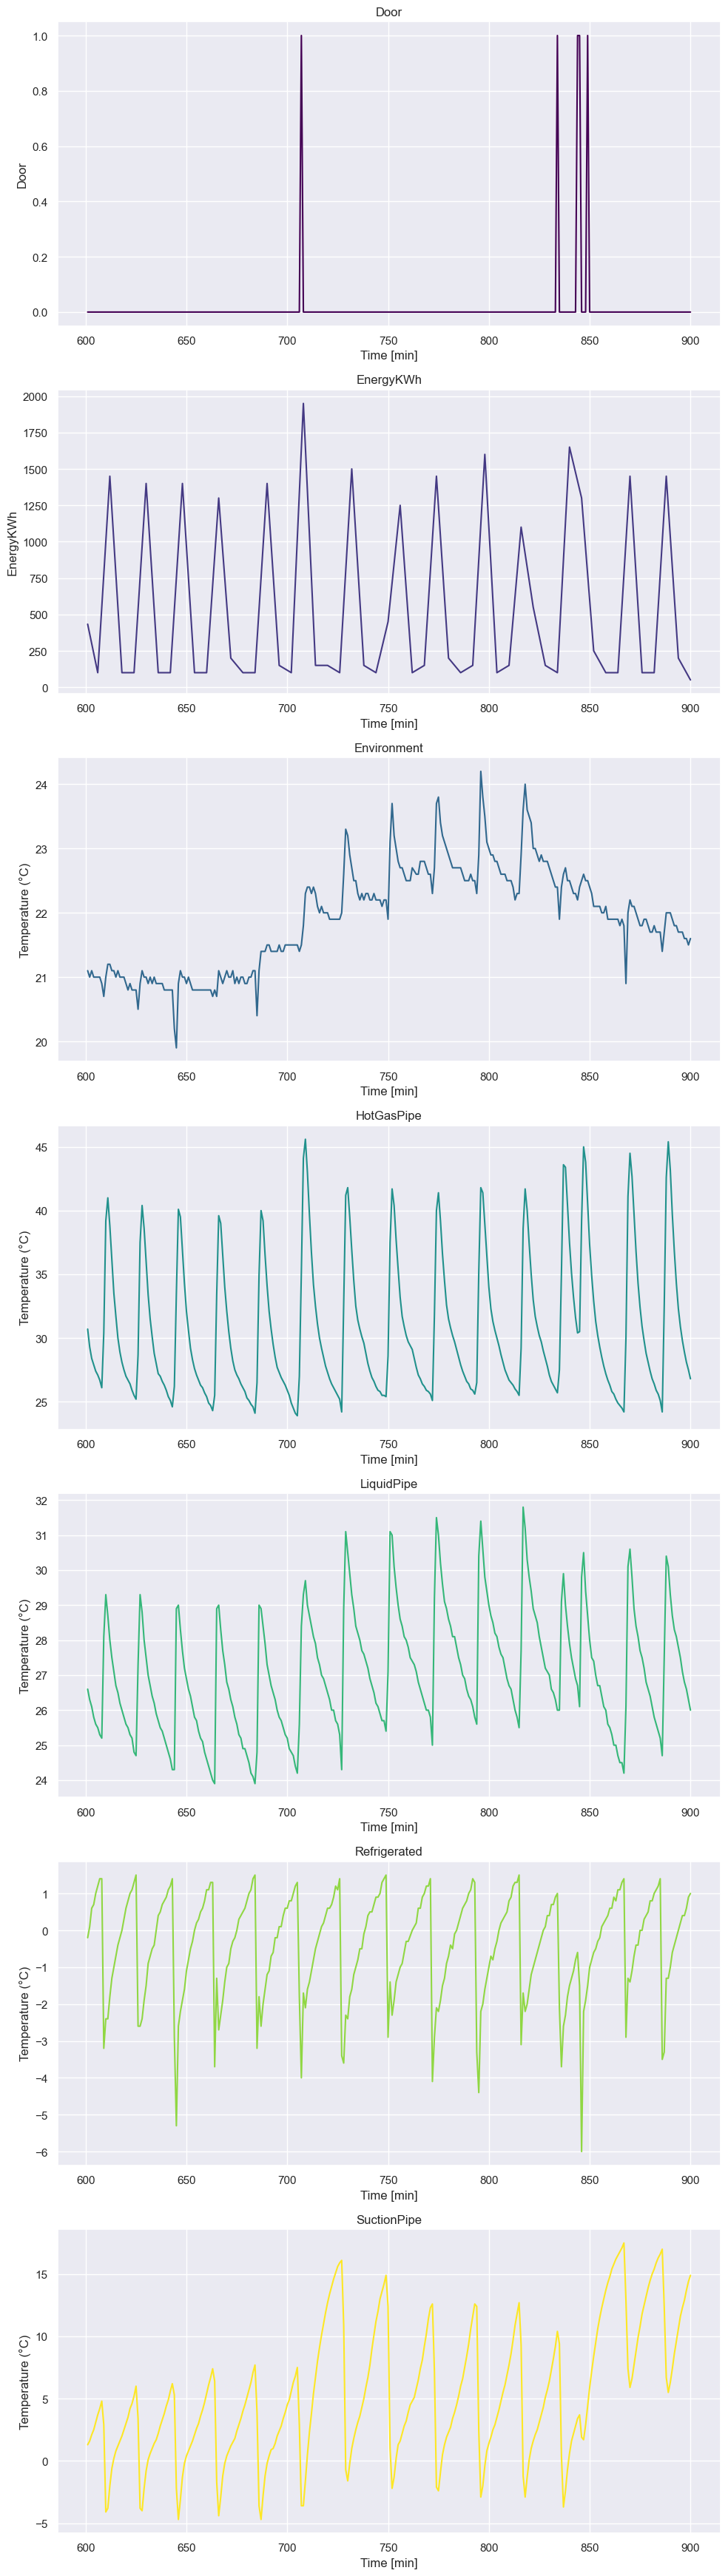

In [12]:
columns = ['Door', 'EnergyKWh', 'Environment', 'HotGasPipe', 'LiquidPipe', 'Refrigerated', 'SuctionPipe']
variable_plot(df3, column=columns, titles=columns)

In [13]:
def dividing_lines(dataframe:pd.DataFrame, colum:str, y_label:str, n_periods:int, period_shift:int, start:int=600, end:int=901) -> None:
    plt.figure(figsize=(10,4))
    plt.plot(dataframe['Time'], dataframe[colum])
    plt.title(f'{colum} with dividing lines for periods')
    plt.ylabel(y_label)
    
    for minute in np.arange(start=start, stop=end, step=n_periods):
        plt.axvline(minute+period_shift, color='red', linestyle='--', alpha=0.4)
    
    plt.show()

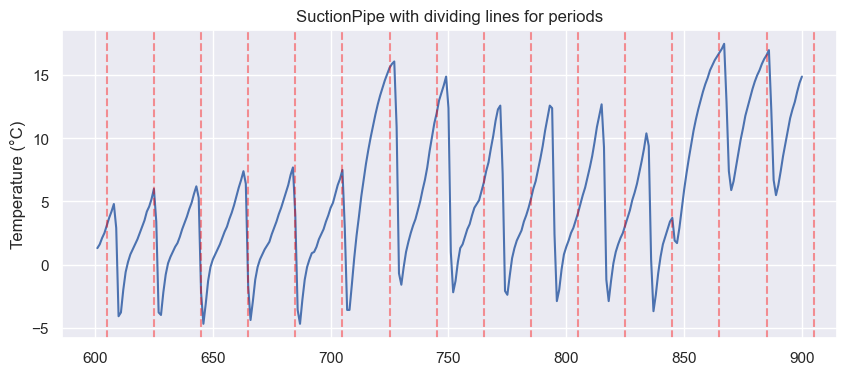

In [14]:
dividing_lines(dataframe=df3, colum='SuctionPipe', y_label='Temperature (°C)', n_periods=20, period_shift=5)

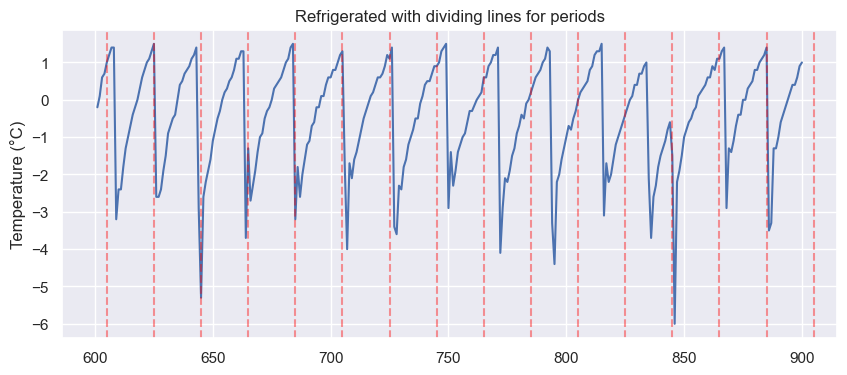

In [15]:
dividing_lines(dataframe=df3, colum='Refrigerated', y_label='Temperature (°C)', n_periods=20, period_shift=5)

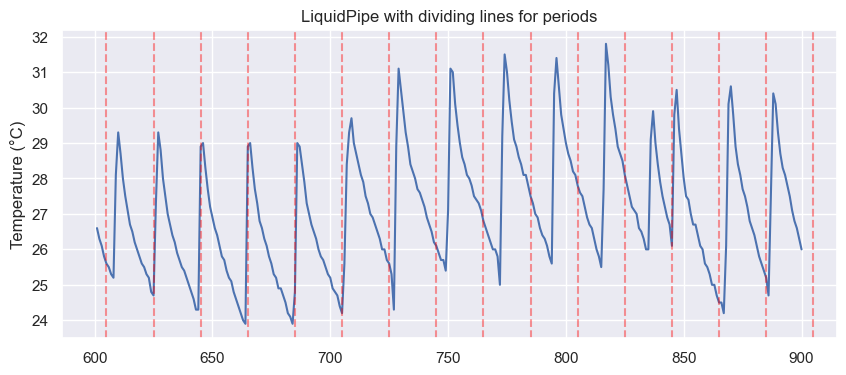

In [16]:
dividing_lines(dataframe=df3, colum='LiquidPipe', y_label='Temperature (°C)', n_periods=20, period_shift=5)

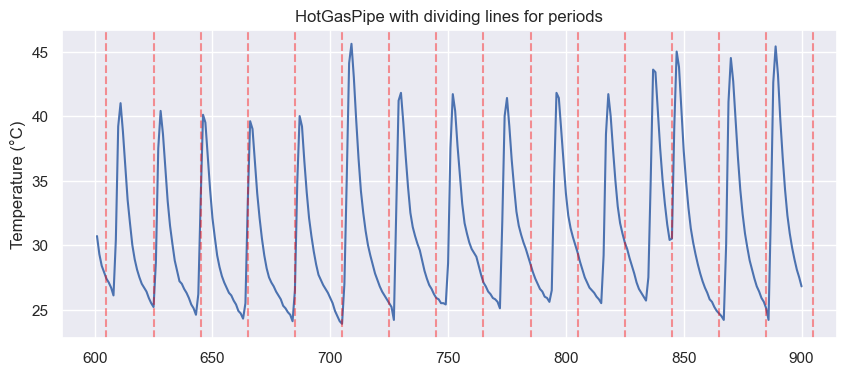

In [17]:
dividing_lines(dataframe=df3, colum='HotGasPipe', y_label='Temperature (°C)', n_periods=20, period_shift=5)

In [43]:
array = df3['HotGasPipe'].to_numpy()

In [50]:
from numpy.fft import fft, fftshift, fftfreq, rfft

In [51]:
array_fft = rfft(array)

In [52]:
array_fft

array([ 9.23130000e+03+0.00000000e+00j,  3.60673543e+01+1.47429053e+02j,
        1.68927208e+01+9.10733115e+01j, -4.45169597e+00-6.40299911e+01j,
       -1.06123145e+01-4.37835590e+01j,  9.90289798e+01+3.61791158e+01j,
        2.91536928e+01+6.43558024e+01j, -9.34361964e+01+9.53004638e+01j,
       -7.15782431e+01-1.07040512e+01j, -5.53078190e+01-9.58570589e+01j,
        4.47490112e+01-4.64067777e+01j,  1.04079700e+02+5.09271920e+01j,
        2.85606406e+01+1.10760871e+02j, -2.43839531e+02+3.90946639e+02j,
        5.29673143e+01-4.43252641e+02j, -4.09241955e+02+6.03651696e+01j,
       -3.38645988e+02+1.18621578e+02j, -1.40827125e+02-7.31602498e+01j,
        1.05642474e+01-1.27635773e+01j,  1.05298484e+02+1.41215499e+01j,
        5.21457033e+01+2.15165039e+00j,  2.35617252e+01-1.37978729e+01j,
        9.72426986e+01-6.60255650e+01j,  8.71162531e+01-9.08233877e+00j,
        7.00561667e+01+4.52213003e+01j, -2.23796115e+01+3.41142903e+01j,
        1.56692993e+01-1.01403628e+02j, -8.82653420

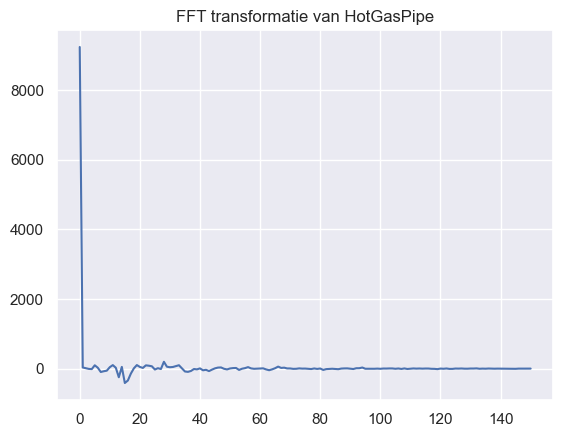

In [55]:
plt.plot(array_fft)
plt.title('FFT transformatie van HotGasPipe')
plt.show()

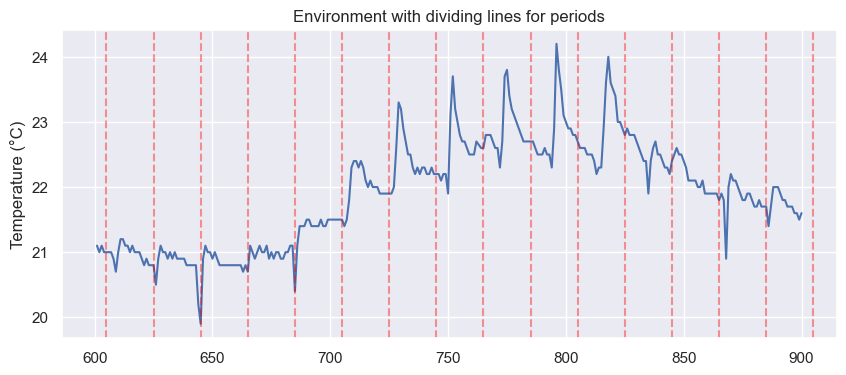

In [18]:
dividing_lines(dataframe=df3, colum='Environment', y_label='Temperature (°C)', n_periods=20, period_shift=5)

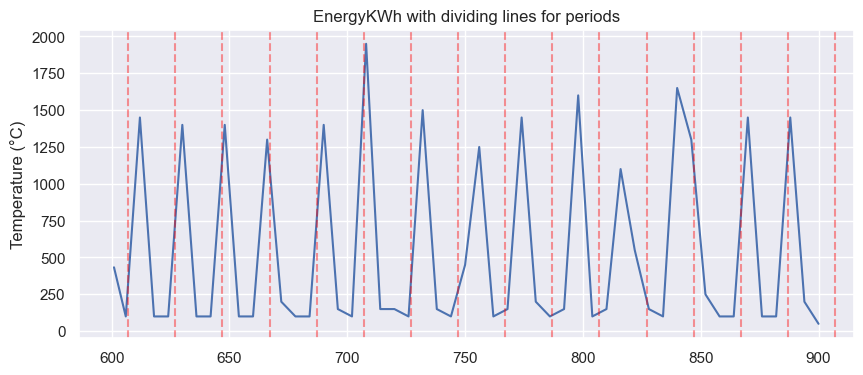

In [19]:
dividing_lines(dataframe=df3, colum='EnergyKWh', y_label='Temperature (°C)', n_periods=20, period_shift=7)

In [21]:
def decompose_plot(dataframe:pd.DataFrame, column:str, period:int) -> None:
    decompose_result = seasonal_decompose(dataframe[column], model='additive', period=period)
    decompose_result.plot()
    plt.xticks(rotation=90)
    plt.show()

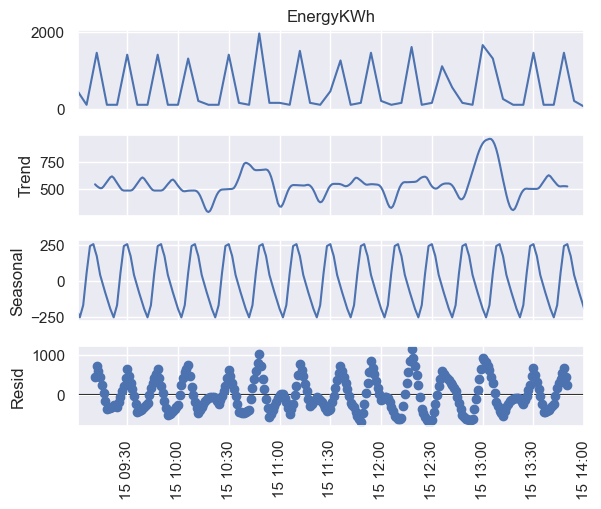

In [22]:
decompose_plot(dataframe=df3, column='EnergyKWh', period=20)

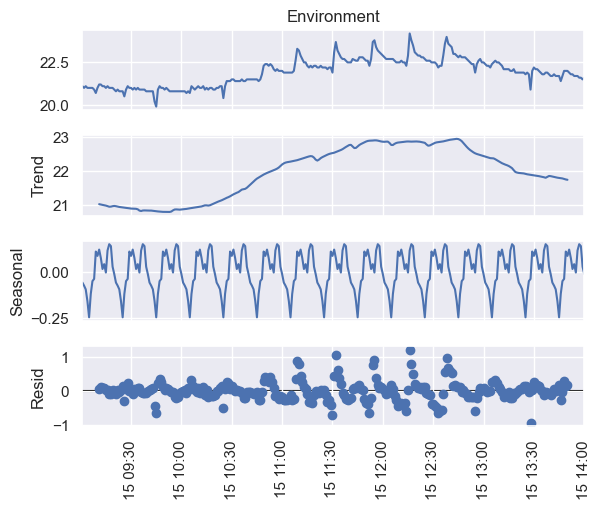

In [23]:
decompose_plot(dataframe=df3, column='Environment', period=20)

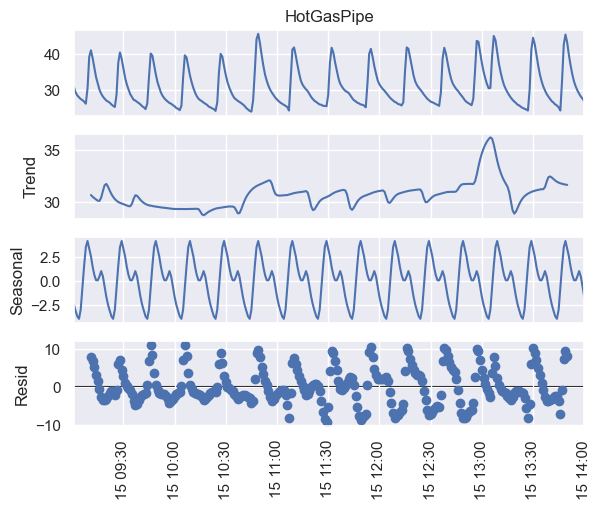

In [24]:
decompose_plot(dataframe=df3, column='HotGasPipe', period=20)

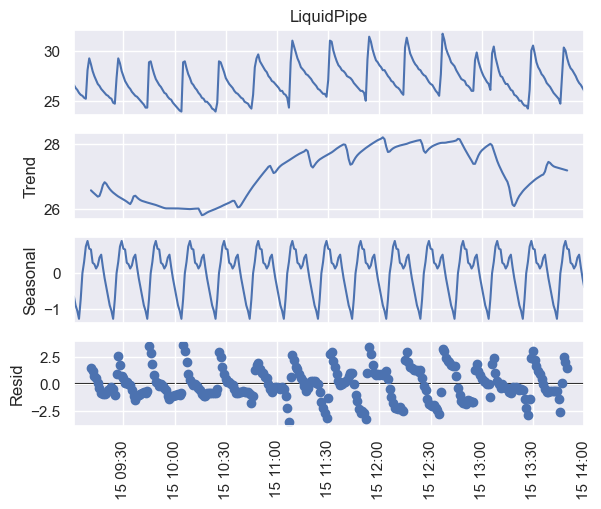

In [25]:
decompose_plot(dataframe=df3, column='LiquidPipe', period=20)

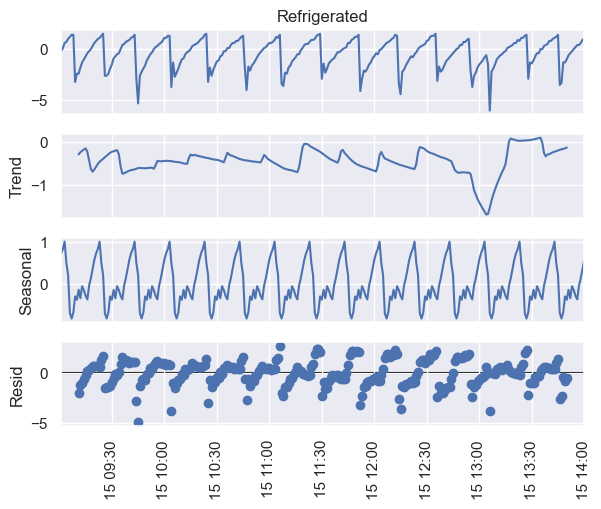

In [26]:
decompose_plot(dataframe=df3, column='Refrigerated', period=20)

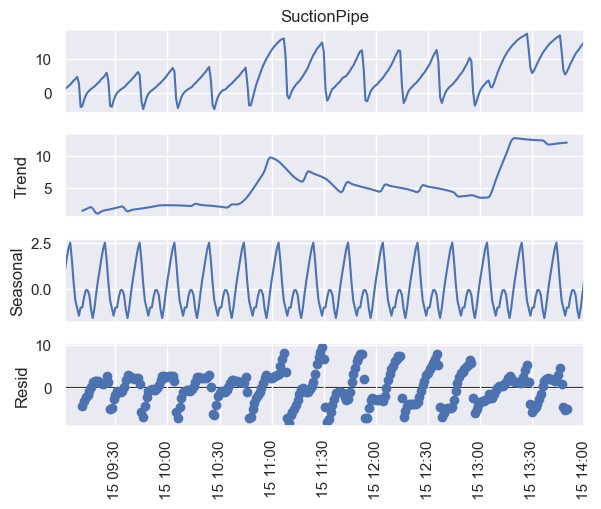

In [27]:
decompose_plot(dataframe=df3, column='SuctionPipe', period=20)

In [28]:
def deviation(dataframe:pd.DataFrame) -> pd.Series:
    rolling_devation = pd.Series(dtype=float, index=dataframe.index)
    
    for minute in rolling_devation.index:
        window = dataframe.loc[:minute]
        rolling_devation.loc[minute] = window.std()
    
    diff_rolling_deviations = rolling_devation.diff().dropna()
    return diff_rolling_deviations

In [29]:
def deviation_plot(deviations: pd.Series) -> None:
    plt.figure(figsize=(12, 6))
    plt.plot(deviations.index, deviations, label='Deviation Difference')
    plt.title('Deviation Differences over time')
    plt.ylabel('Difference')
    plt.xlabel('Time [month-day-hour]')
    plt.legend()
    plt.show()

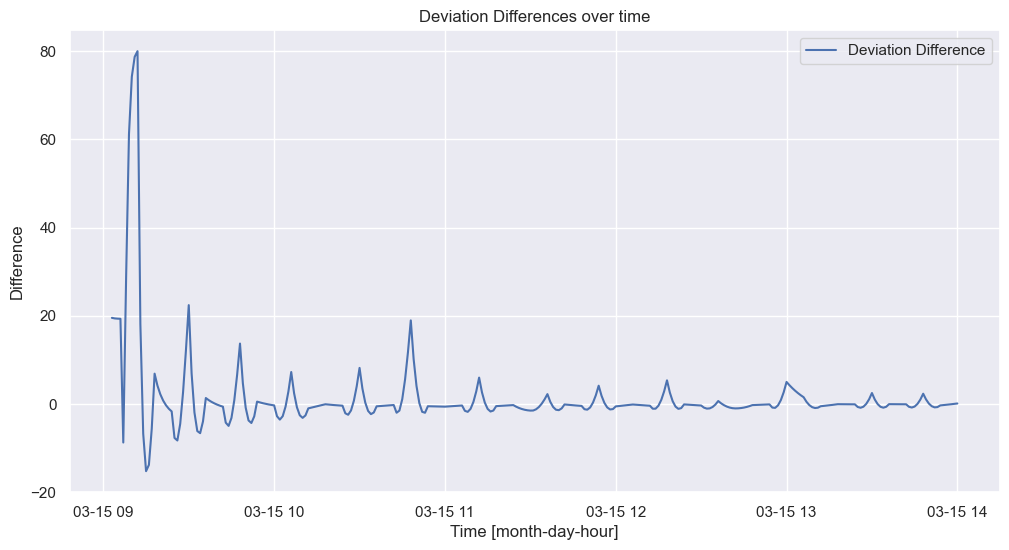

In [30]:
env_deviation = deviation(df3['EnergyKWh'])
deviation_plot(env_deviation)

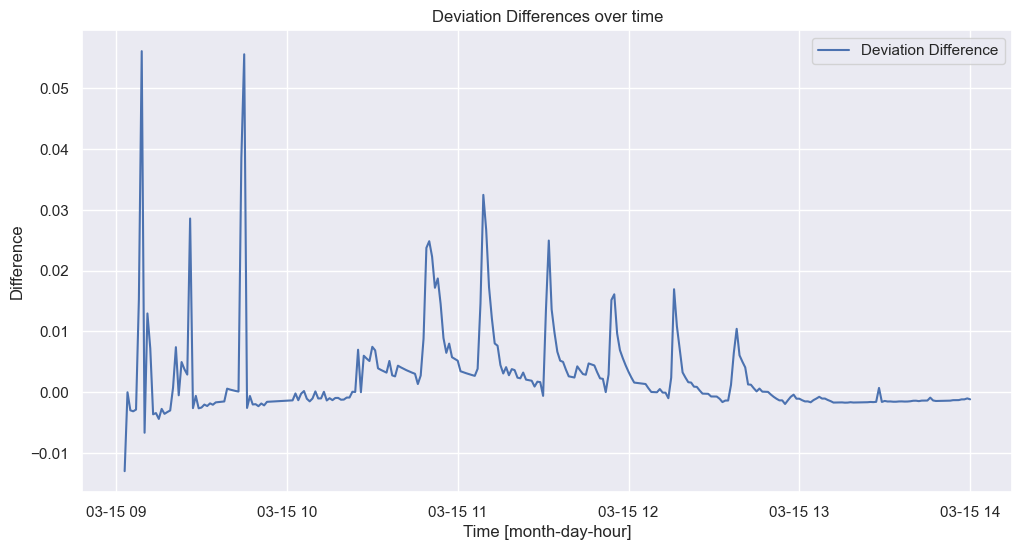

In [31]:
env_deviation = deviation(df3['Environment'])
deviation_plot(env_deviation)

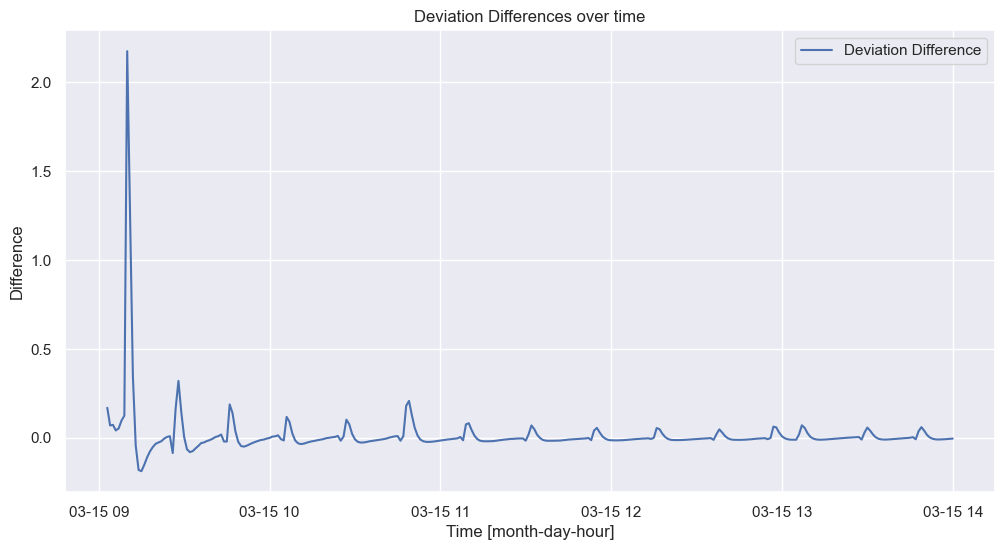

In [32]:
env_deviation = deviation(df3['HotGasPipe'])
deviation_plot(env_deviation)

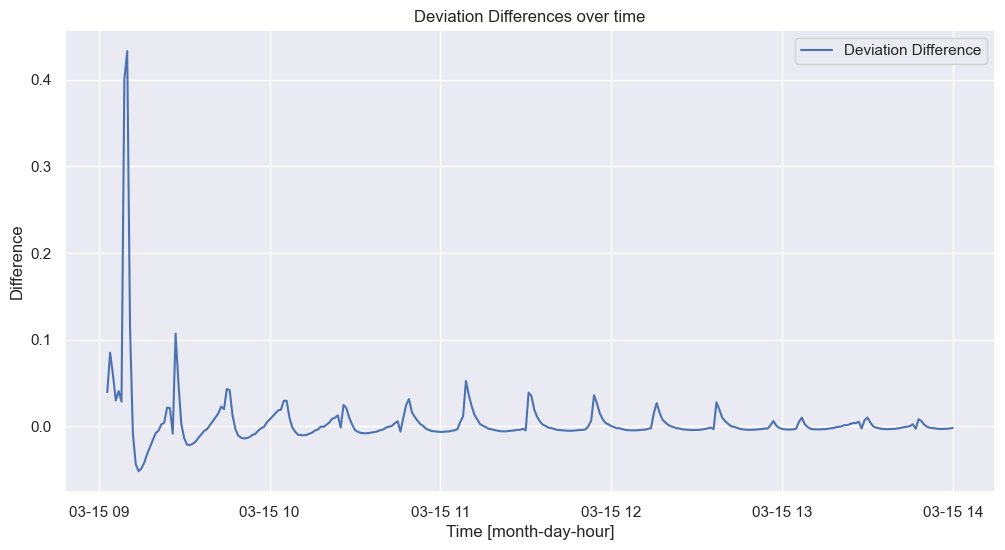

In [33]:
env_deviation = deviation(df3['LiquidPipe'])
deviation_plot(env_deviation)

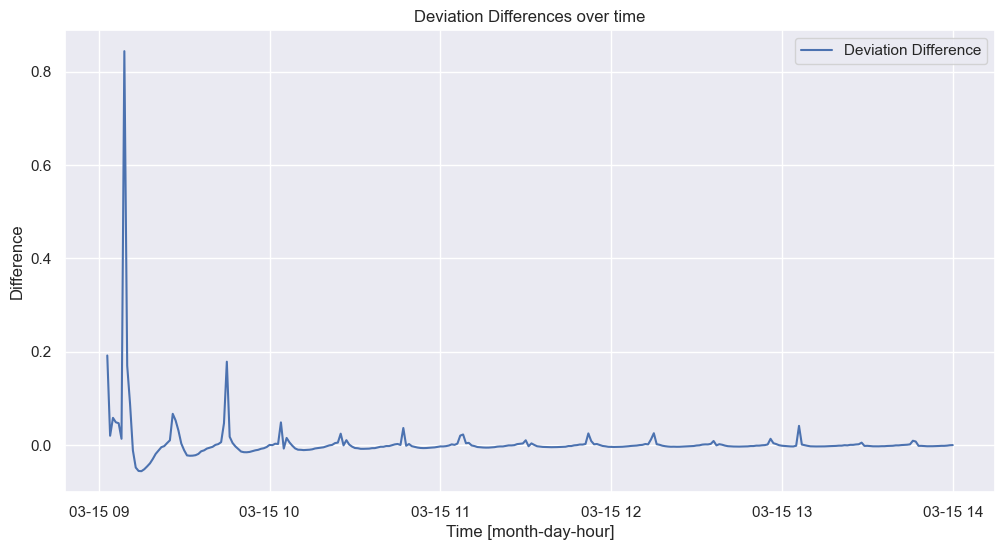

In [34]:
env_deviation = deviation(df3['Refrigerated'])
deviation_plot(env_deviation)

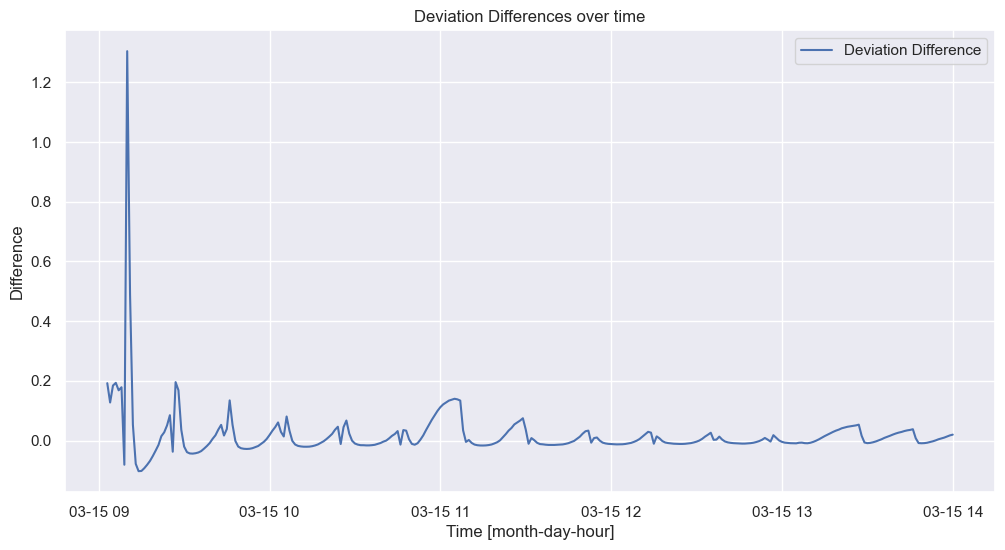

In [35]:
env_deviation = deviation(df3['SuctionPipe'])
deviation_plot(env_deviation)

In [63]:
df4 = df3.reset_index()
pd.to_datetime(df4['Date'])
df4.set_index('Date', inplace=True)
time_elapsed_min = (df4.index - df4.index[0].total_seconds/60    

AttributeError: 'Timestamp' object has no attribute 'total_seconds'